# Posterior Bayes Vulnerability

In [1]:
import collections
import math
import numpy as np
import pandas as pd
from sympy.utilities.iterables import partitions
from sympy.functions.combinatorial.numbers import stirling
import matplotlib.pyplot as plt 
pd.set_option('precision', 10)
%matplotlib inline

In [2]:
from decimal import Decimal

## Variables To Test Functions

In [3]:
k = 3

In [4]:
n = 10

In [5]:
probs = [1/2, 1/3, 1/6]

In [6]:
uni_probs = [1/3, 1/3, 1/3]

In [7]:
range_max = 200

## Note on large n's

Due to the very large index partitions that correspond to every integer partitions for n>600, I have created new versions of the 3 functions that use the Decimal data structure and rely on log10 math. These functions have prefix `wip`

## Functions

__uni_post_bayes_vuln__ calculates the posterior Bayes vulnerability under a *uniform* prior using Stirling numbers of the second kind. <br>
n: size of the column <br>
k: number of unique plaintext values/diseases <br>
$$V_1[\pi \triangleright C] = \frac{\sum_{i=1}^{min(n,k)} s2(n, i)}{k^n} $$

In [3]:
def uni_post_bayes_vuln(n, k):
    num = 0
    den = 0
    for i in range(1, k+1): # goes from 1-k
        num = num + stirling(n, i)
    den = pow(k, n)
    return num/den

In [9]:
uni_post_bayes_vuln(3, k)

5/27

__prior_bayes_vuln__ calculates the prior Bayes vulnerability <br>
n: the size of the column <br>
Pi: the probability distribution of individual diseases <br>
In this case, the adversary would choose the most likely disease for every column.<br>
Therefore, the prior Bayes vulnerability is $(\max\pi)^n$

In [3]:
def prior_bayes_vuln(n, Pi):
    Pi.sort(reverse=True) 
    return pow(Pi[0],n)

__calc_set_partitions(n,p)__ calculates the number of set partitions
<br>
n: positive integer
<br>
p: a unique integer partition, as a python dictionary
<br>
Example:
```python
calc_set_partitions(6, {4:1, 1:2})
```
Output:
```python
15.0
```
Specific formula:<br>
$$\text{set partitions}(6,\{4:1, 1:2\}) = \frac{6!}{\left(4!\right)1! \times \left(1!1!\right)2!} $$

Generalized formula:<br>
With an interger partition $p$ containing integers $i$, each with multiplicity of $m$,
$$\text{set partitions}(n,p)=\frac{n!}{\prod_{i \in p} i!^m m!}$$

In [4]:
def calc_set_partitions(n,p):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    num_index = num / den
    return num_index

In [5]:
def wip_calc_set_partitions(n,p,base):
    num = math.factorial(n)
    den = 1
    mul = 0
    for i in p.keys():
        mul = p[i]
        den = den * pow(math.factorial(i), mul) * math.factorial(mul)
    num_log = math.log(num, base)
    den_log = math.log(den, base)
    num_index_log = num_log - den_log
    return Decimal(num_index_log)

__calc_max_prob__ calculates the maximum probability of a unique integer partition <br>
Multiplies the largest fraction in $\pi$ to the power of the largest integer in the integer partition in decending order<br>
p: a unique integer partition, as a python dictionary<br>
Pi: the prior probability distribution<br>
Example:
```python
calc_max_prob({4:1,1:2},[1/2, 1/3, 1/6])
```
Output:
```python
0.003472222222222222
``` 
which is equal to 1/288

In [6]:
def calc_max_prob(p, Pi):
    Pi.sort(reverse=True)
    frac = 1
    ind = 0
    val = -1
    for key in sorted(p.keys(), reverse=True):
        val = p[key]
        for i in range(val):
            frac = frac * pow(Pi[ind], key)
            ind = ind + 1
    return frac

In [7]:
def wip_calc_max_prob(p, Pi, base):
    Pi.sort(reverse=True)
    frac = Decimal(1)
    ind = 0
    val = -1
    for key in sorted(p.keys(), reverse=True):
        val = p[key]
        for i in range(val):
            pi_ind = Decimal(Pi[ind])
            power = pi_ind ** key
            frac = frac * power
            ind = ind + 1
    try: 
        frac_log = frac.log10()
    except:
        print("Domain error, presumably, frac: ", frac)
    return frac_log

$$ V_1 [C \triangleright \pi ]  = \sum_{p=1}^{|\text{partitions}(n, k)|} \text{set partitions}(n, p)\times\text{max prob} (p, \pi )  $$

__partitions(n, m)__ generates a dictionary of integer partitions
<br>
n: positive integer
<br>
m: the maximum number of parts in partition
<br>
Outputs a dictionary where the keys are the integers and the values are the number of times that integer occurs

Example:
```python
for p in partitions(6,3):
    print(p)
```
Output:
```python
{6:1}
{5:1, 1:1}
{4:1, 2:1}
{4:1, 1:2}
{3:2}
{3:1, 2:1, 1:1}
{2:3}
```
For every dictionary, __nonuni_post_bayes_vuln__ multiplies the number of set partitions and its max probability.
These numbers are added together for all integer partitions to calculate the final posterior bayes vulnerability.

In [8]:
def wip_nonuni_post_bayes_vuln(n, k, Pi):
    #data = []
    base = 10
    pbvsum = 0
    for p in partitions(n, m=k):  
        log_num = wip_calc_set_partitions(n,p, base)
        log_frac = wip_calc_max_prob(p, Pi, base)
        log_val = log_num + log_frac
        per_p = base ** log_val
        #df_data = {'log_num': log_num, 'log_frac': log_frac, 'per_p': per_p}
        pbvsum = pbvsum + per_p
        #data.append(df_data)
    #df = pd.DataFrame(data=data)
    return pbvsum #df

In [9]:
def nonuni_post_bayes_vuln(n, k, Pi):
    pbvsum = 0
    for p in partitions(n, m=k):  
        num = calc_set_partitions(n,p)
        frac = calc_max_prob(p, Pi)
        val = num * frac
        pbvsum = pbvsum + val
    return pbvsum

#### Test Calculations

Large n and posterior Bayes vulnerability
- n = 600 bayes =  0.7558
- n = 700 bayes =  0.77289
- n = 1000 bayes = 0.814495
- n = 1500 bayes = 0.86339
- n = 2000 bayes = 0.8971
- n = 2500 bayes = 0.9214
- n = 3000 bayes = 0.93938
- n = 5000 bayes = 0.9772795

In [17]:
prior_bayes_vuln(6, probs)

0.015625

**Buffer overflow tests**

In [40]:
probs = [1/2, 26/100, 24/100]
n = 600
k = 3
nonuni_post_bayes_vuln(n, k, probs)

0.755808776009901

In [169]:
probs = [1/2, 26/100, 24/100]
n = 700
k = 3
wip_nonuni_post_bayes_vuln(n, k, probs)

Decimal('0.7728972866353035288117121889')

In [170]:
probs = [1/2, 26/100, 24/100]
n = 1000
k = 3
wip_nonuni_post_bayes_vuln(n, k, probs)

Decimal('0.8144951930042898411344920083')

In [172]:
probs = [1/2, 26/100, 24/100]
n = 1500
k = 3
wip_nonuni_post_bayes_vuln(n, k, probs)

Decimal('0.8633911524105116045247844115')

In [19]:
probs = [1/2, 26/100, 24/100]
n = 1700
k = 3
wip_nonuni_post_bayes_vuln(n, k, probs)

Decimal('0.8782846637607565804351535450')

In [26]:
probs = [1/2, 26/100, 24/100]
n = 2000
k = 3
psum, df = wip_nonuni_post_bayes_vuln(n, k, probs)
print("psum: ", psum)

psum:  0.8971022715409918911928645327


In [27]:
df

,log_frac,log_num,per_p
0,-602.0599913279623904274777894,0,8.709809816217216675576196477E-603
1,-602.3439879843275912530079993,3.301029995664066518656909465789794921875,9.058202208867685267095981142E-600
2,-602.6279846406927920785382092,6.30081279411751893348991870880126953125,4.707910016029483362867502200E-597
3,-602.6627467469520040509301403,6.30081279411751893348991870880126953125,4.345763091719522794905499066E-597
4,-602.9119812970579929040684191,9.1242870232881614356301724910736083984375,1.630443396752612563018892602E-594
5,-602.9467434033172048764603502,9.6014082780084208934567868709564208984375,4.515074021782672067508586513E-594
6,-603.1959779534231937295986289,11.8226050968305571586824953556060791015625,4.232794102306100421098472832E-592
7,-603.2307400596824057019905600,12.4246650881586901959963142871856689453125,1.562877822390558759623405067E-591
8,-603.2655021659416176743824911,12.2997263515508166165091097354888916015625,1.081992338579141322803421054E-591
9,-603.4799746097883945551288388,14.423795629447340616025030612945556640625,8.786603309360431196757622846E-590


In [29]:
probs = [1/2, 26/100, 24/100]
n = 2500
k = 3
psum = wip_nonuni_post_bayes_vuln(n, k, probs)
print("psum: ", psum)

psum:  0.9214023071514320926287212239


In [30]:
probs = [1/2, 26/100, 24/100]
n = 3000
k = 3
psum = wip_nonuni_post_bayes_vuln(n, k, probs)
print("psum: ", psum)

psum:  0.9393804817442822090419274014


In [31]:
probs = [1/2, 26/100, 24/100]
n = 5000
k = 3
psum = wip_nonuni_post_bayes_vuln(n, k, probs)
print("psum: ", psum)

psum:  0.9772795678382588259441973673


In [32]:
probs = [1/2, 26/100, 24/100]
n = 8000
k = 3
psum = wip_nonuni_post_bayes_vuln(n, k, probs)
print("psum: ", psum)

psum:  0.9943056786124175045256826593


At n = 200, posterior Bayes vulnerability is slightly less than half since there is still a chance that the large block was b or c, although it's very small.

.499985...

In [18]:
probs = [1/2, 1/4, 1/4]
n = 200
k = 3
wip_vuln = wip_nonuni_post_bayes_vuln(n, k, probs)
reg_vuln = nonuni_post_bayes_vuln(n, k, probs)
print("with wip: ", wip_vuln)
print("with reg: ", reg_vuln)

with wip:  0.4999859734202456929158193577
with reg:  0.4999859734203035


In [15]:
745/1728

0.43113425925925924

### Functions to graph different priors, k, and n-ranges

***Manually write correct graph heading***

In [10]:
import matplotlib as mpl
font_choice = 14
plt.rcParams.update(plt.rcParamsDefault)
rc_fonts = {
    "text.usetex": True,
    "font.size": font_choice,
    'mathtext.default': 'regular',
    'axes.titlesize': font_choice,
    "axes.labelsize": font_choice,
    "legend.fontsize": font_choice,
    "xtick.labelsize": font_choice,
    "ytick.labelsize": font_choice,
    'figure.titlesize': font_choice,
    'figure.figsize': (8,5.25),
    'text.latex.preamble': [r'\usepackage{amsmath,nicefrac, sansmath}', 
                            r'\sansmath'],
    "font.family": "sans-serif",#"font.sans-serif": "computer modern",
    }
mpl.rcParams.update(rc_fonts)

In [ ]:
    #plt.rc('text', usetex = True)
    #plt.rcParams['text.latex.unicode']=True
    plt.rcParams.update(plt.rcParamsDefault)
    params = {'text.latex.preamble' : [r'\usepackage{amsmath}, \usepackage{nicefrac}']}
    plt.rcParams.update(params)
    #plt.rcParams.update(plt.rcParamsDefault)
    #plt.rc('text.latex', preamble=r'\usepackage{amsmath}, \usepackage{nicefrac}')

In [78]:
plt.rcParams.update(plt.rcParamsDefault)

In [40]:
def graph_it_bayes(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    y_posterior = df["posterior"].iloc[-1] # saves last posterior y
    y_prior = df["prior"].iloc[-1] # save last prior y for annotation
    
    plt.plot('n', 'prior', 
             data=df,
             label="prior")
    plt.plot('n', 'posterior',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="posterior")
    plt.xlabel('n')
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    # green dot for last y posterior vulnerability
    plt.annotate('%.4f' % y_posterior,
                 xy=[n_range, y_posterior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_posterior, 
             marker = 'o', 
             markerfacecolor='green',
             markeredgecolor='green')
    
    # green dot for last y prior vulnerability
    plt.annotate('%.4f' % y_prior,
                 xy=[n_range, y_prior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_prior, 
             marker = 'o', 
             markerfacecolor='blue',
             markeredgecolor='blue')
    
    # title rounds the prior
    plt.title(r'Bayes vulnerability, k = 15') #fontsize = 16, y=1.02
    plt.legend(loc='upper left')
    # legend adjusted so it doesn't run into annotations
    #plt.legend(loc='center left', 
     #         bbox_to_anchor= (1.01, .5),
      #        frameon=False)
    plt.show()
    plt.close()

In [12]:
def df_bayes_prior_post(n_range, k, probs, wip):
    post_bayes_vs = []
    prior_bayes_vs = []
    for i in range(n_range):
        if (i % 10 == 0):
            print("***i = ", i)
            if wip == True:
                post = wip_nonuni_post_bayes_vuln(i+1, k, probs)
            else:
                post = nonuni_post_bayes_vuln(i+1, k, probs)
            post_bayes_vs.append(post)
            print("Post: ", post)
            prior = pow(probs[0], i+1)
            prior_bayes_vs.append(prior)
            print("Prior: ", prior)
    df = pd.DataFrame(
        {'prior':prior_bayes_vs,
         'posterior':post_bayes_vs
        }
    )
    return df

# Realistic Tests

In [32]:
def graph_some(df):
    plt.plot('n',
             'prior', 
             data = df,
             label = 'prior')
    plt.plot('n',
             'posterior',
             color = 'green',
             data = df,
             linestyle ='--',
             marker = '', 
             label = "posterior")
    plt.xlabel('n')
    plt.ylabel('Bayes vulnerability')
    plt.title(r'Bayes vulnerability, k = 10')
    plt.legend(loc='upper left')
    plt.show()
    plt.close()

## Realistic Test 1

Notes from https://www-doh.state.nj.us/doh-shad/query/result/ub/UB10AllInpat/CrudeRateHosp.html

per 10k

In [44]:
n_range = 151
k = 15
probs = [0.128535187,
        0.108428075,
        0.104387861,
        0.089636381,
        0.084374706,
        0.081461994,
        0.071408437, # other
        0.060979047,
        0.057314667,
        0.050267782,
        0.04914028,
        0.037301513,
        0.028093583,
        0.026496289,
        0.022174199 
]

In [27]:
data = {'n': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151],
       'prior': [0.128535187, 
                 1.5821307480274093e-10, 
                 1.947433821256875e-19, 
                 2.397082853552791e-28, 
                 2.9505527448877907e-37, 
                 3.631815015263989e-46,
                 4.470376043251715e-55,
                 5.5025550266431296e-64,
                 6.77305701540301e-73,
                 8.336909147074145e-82,
                 1.0261843945578084e-90,
                 1.2631232907264528e-99,
                 1.5547697431738174e-108,
                 1.913755349169854e-117,
                 2.3556282546378195e-126,
                 2.899526565114528e-135],
       'posterior': [0.128535187, 
                     1.7317909956299747e-05, 
                     4.000592413443685e-07, 
                     6.547095588570011e-08, 
                     3.054059379112515e-08, 
                     2.5370026952546667e-08, 
                     2.877602855448832e-08, 
                     3.8469615527978274e-08, 
                     5.5474196153163615e-08, 
                     8.198053800290725e-08, 
                     1.2087777517032836e-07, 
                     1.7564755072885535e-07, 
                     2.5033931853551166e-07, 
                     3.495732199391509e-07, 
                     4.785512192815791e-07, 
                     6.430683544279491e-07]}
df15 = pd.DataFrame(data, columns=['n', 'prior', 'posterior'])

In [28]:
df15

,n,prior,posterior
0,1,1.2853518700e-01,0.1285351870
1,11,1.5821307480e-10,0.0000173179
2,21,1.9474338213e-19,0.0000004001
3,31,2.3970828536e-28,0.0000000655
4,41,2.9505527449e-37,0.0000000305
5,51,3.6318150153e-46,0.0000000254
6,61,4.4703760433e-55,0.0000000288
7,71,5.5025550266e-64,0.0000000385
8,81,6.7730570154e-73,0.0000000555
9,91,8.3369091471e-82,0.0000000820


In [29]:
df15.to_csv(r'data\df_k_15_bayes', index = None, header = True)

In [42]:
df_15k = pd.read_csv('data\df_k_15_bayes')

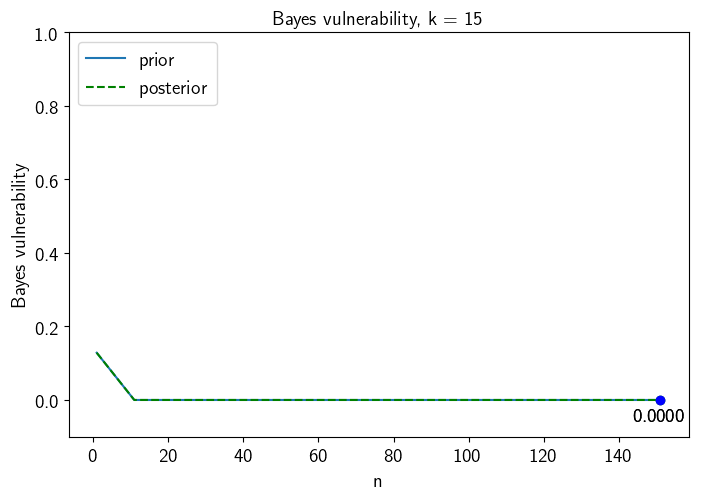

In [45]:
graph_it_bayes(n_range, k, probs, df_15k)

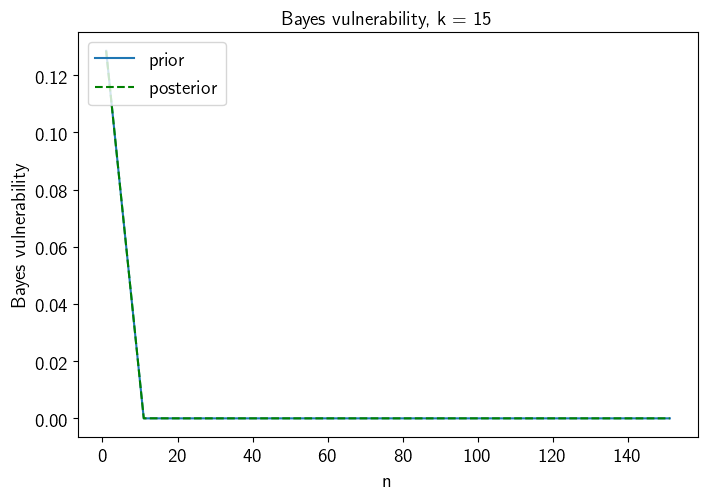

In [16]:
graph_some(df_15k)

In [17]:
df15zoom = df_15k[df_15k.n > 20]

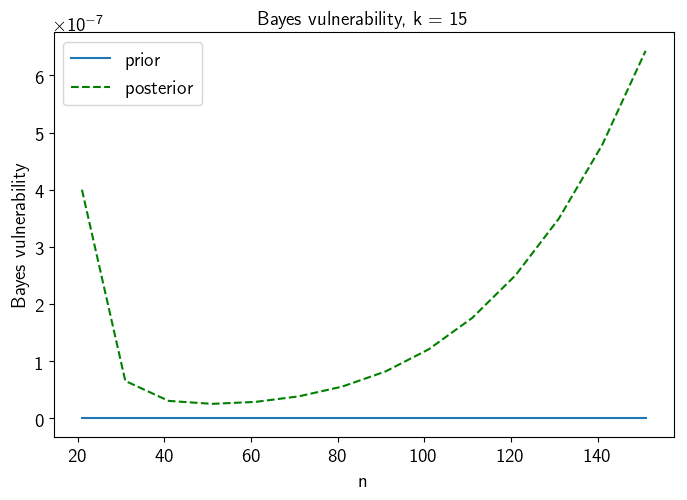

In [18]:
graph_some(df15zoom)

In [26]:
wip_flag = False
df15 = df_bayes_prior_post(n_range, k, probs, wip_flag)

***i =  0
Post:  0.128535187
Prior:  0.128535187
***i =  10
Post:  1.7317909956299747e-05
Prior:  1.5821307480274093e-10
***i =  20
Post:  4.000592413443685e-07
Prior:  1.947433821256875e-19
***i =  30
Post:  6.547095588570011e-08
Prior:  2.397082853552791e-28
***i =  40
Post:  3.054059379112515e-08
Prior:  2.9505527448877907e-37
***i =  50
Post:  2.5370026952546667e-08
Prior:  3.631815015263989e-46
***i =  60
Post:  2.877602855448832e-08
Prior:  4.470376043251715e-55
***i =  70
Post:  3.8469615527978274e-08
Prior:  5.5025550266431296e-64
***i =  80
Post:  5.5474196153163615e-08
Prior:  6.77305701540301e-73
***i =  90
Post:  8.198053800290725e-08
Prior:  8.336909147074145e-82
***i =  100
Post:  1.2087777517032836e-07
Prior:  1.0261843945578084e-90
***i =  110
Post:  1.7564755072885535e-07
Prior:  1.2631232907264528e-99
***i =  120
Post:  2.5033931853551166e-07
Prior:  1.5547697431738174e-108
***i =  130
Post:  3.495732199391509e-07
Prior:  1.913755349169854e-117
***i =  140
Post:  4.78

KeyboardInterrupt: 

## Realistic Test 2

Distribution from Development and Implementation of an Inpatient Acute Palliative Care Service...
Table 5, Prevalance of Major Diagnostic Categories
in Journal of Palliative Medicine, 2002

In [35]:
n_range = 200
k = 10
probs = [0.413,
        0.174,
        0.14,
        0.096, # other
        0.094,
        0.035,
        0.024,
        0.017, 
        0.004,
        0.002,
]

In [29]:
df_10k = pd.read_csv('data\df_k_10_bayes')

In [30]:
df_10k

,prior,posterior,n
0,4.1300000000e-01,0.4130000000,1.0
1,5.9628044681e-05,0.0352092141,11.0
2,8.6089678267e-09,0.0240033316,21.0
3,1.2429441119e-12,0.0237199456,31.0
4,1.7945357637e-16,0.0253689326,41.0
5,2.5909118329e-20,0.0278391061,51.0
6,3.7407023375e-24,0.0308275760,61.0
7,5.4007449423e-28,0.0341644813,71.0
8,7.7974784680e-32,0.0377289556,81.0
9,1.1257830375e-35,0.0414318037,91.0


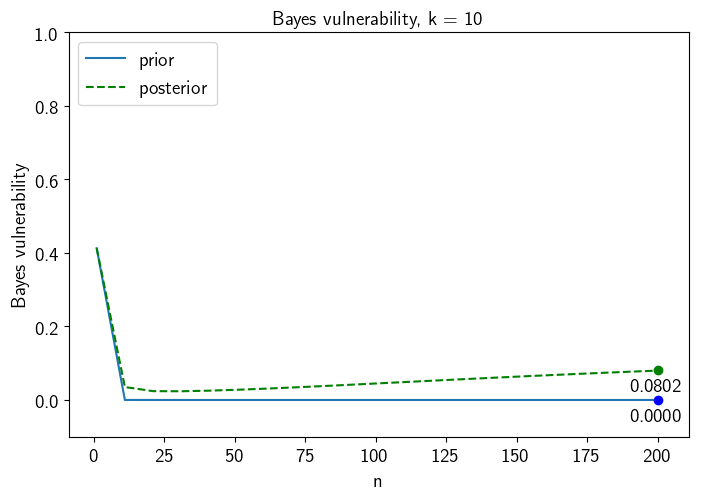

In [39]:
graph_it_bayes(n_range, k, probs, df_10k)

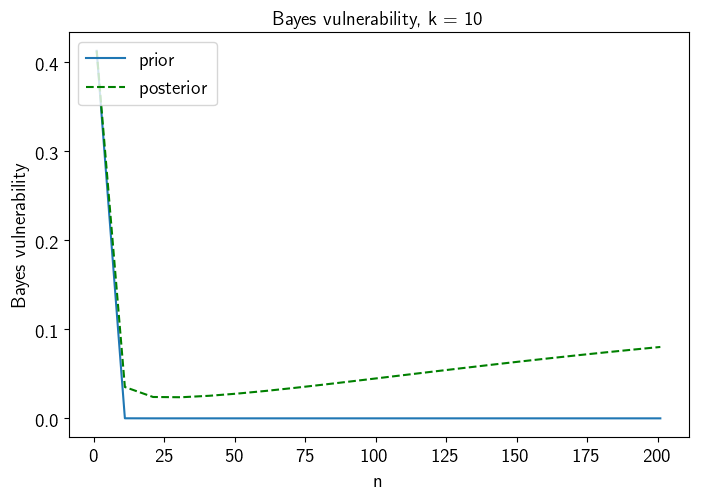

In [33]:
graph_some(df_10k)

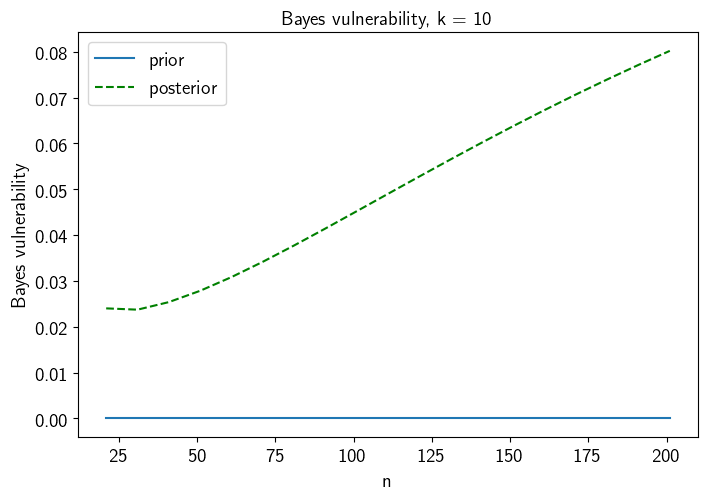

In [34]:
df10zoom = df_10k[df_10k.n > 20]
graph_some(df10zoom)

In [28]:
df_10k.to_csv(r'data\df_k_10_bayes', index = None, header = True)

In [41]:
i = 150
post = nonuni_post_bayes_vuln(i+1, k, probs)
print("Post: ", post)
prior = pow(probs[0], i+1)
print("Prior: ", prior)

Post:  0.06378559989229537
Prior:  1.0196656755177402e-58


In [47]:
i = 160
post = nonuni_post_bayes_vuln(i+1, k, probs)
print("Post: ", post)
prior = pow(probs[0], i+1)
print("Prior: ", prior)

Post:  0.06728303184174265
Prior:  1.4721711975581802e-62


In [48]:
i = 170
post = nonuni_post_bayes_vuln(i+1, k, probs)
print("Post: ", post)
prior = pow(probs[0], i+1)
print("Prior: ", prior)

Post:  0.0706788997625596
Prior:  2.1254888606693906e-66


In [49]:
i = 180
post = nonuni_post_bayes_vuln(i+1, k, probs)
print("Post: ", post)
prior = pow(probs[0], i+1)
print("Prior: ", prior)

Post:  0.07396755206554788
Prior:  3.068734739765974e-70


In [50]:
i = 190
post = nonuni_post_bayes_vuln(i+1, k, probs)
print("Post: ", post)
prior = pow(probs[0], i+1)
print("Prior: ", prior)

Post:  0.07714546199199117
Prior:  4.430572691912747e-74


In [51]:
i = 200
post = nonuni_post_bayes_vuln(i+1, k, probs)
print("Post: ", post)
prior = pow(probs[0], i+1)
print("Prior: ", prior)

Post:  0.08021077327062215
Prior:  6.39676480470905e-78


In [40]:
wip_flag = False
df10 = df_bayes_prior_post(n_range, k, probs, wip_flag)

***i =  0
Post:  0.413
Prior:  0.413
***i =  10
Post:  0.0352092141258092
Prior:  5.962804468070478e-05
***i =  20
Post:  0.024003331635383377
Prior:  8.608967826741225e-09
***i =  30
Post:  0.023719945604964838
Prior:  1.242944111931418e-12
***i =  40
Post:  0.025368932608129204
Prior:  1.7945357637255576e-16
***i =  50
Post:  0.027839106079661346
Prior:  2.5909118329431048e-20
***i =  60
Post:  0.030827575953016287
Prior:  3.740702337493902e-24
***i =  70
Post:  0.03416448133414013
Prior:  5.400744942307585e-28
***i =  80
Post:  0.03772895558077493
Prior:  7.797478468014697e-32
***i =  90
Post:  0.04143180368457431
Prior:  1.1257830375002758e-35
***i =  100
Post:  0.04520664461633676
Prior:  1.6253811443304113e-39
***i =  110
Post:  0.049003661133375565
Prior:  2.3466900604675264e-43
***i =  120
Post:  0.05278521393126254
Prior:  3.388100236739067e-47
***i =  130
Post:  0.05652280544481145
Prior:  4.891665673098875e-51
***i =  140
Post:  0.060194945064118426
Prior:  7.062480855172144

### Graphs

In [14]:
def graph_bayes_prior_post(n_range, k, probs):
    post_bayes_vs = []
    prior_bayes_vs = []
    for i in range(n_range):
        post_bayes_vs.append(nonuni_post_bayes_vuln(i+1, k, probs))
        prior_bayes_vs.append(prior_bayes_vuln(i+1, probs))
    df = pd.DataFrame(
        {'prior':prior_bayes_vs,
         'posterior':post_bayes_vs
        }
    )
    if k == 3:
        graph_it_bayes(n_range, k, probs, df)
    elif k == 4:
        graph_it_bayes_4(n_range, k, probs, df)
    else:
        raise ValueError("k is weird")
    return df

In [137]:
n = 200
k = 3
probs = [1/3, 1/3, 1/3]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  3.764861949598985e-96
The posterior bayes vuln:  0.1666666666666648


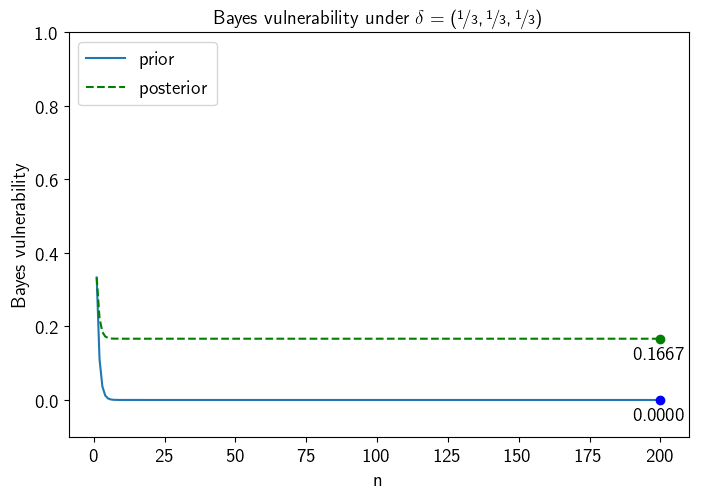

In [138]:
dfuni = graph_bayes_prior_post(200, 3, [1/3, 1/3, 1/3])

In [132]:
n = 10
k = 3
probs = [1/2, 1/3, 1/6]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  0.0009765625
The posterior bayes vuln:  0.5100027327674895


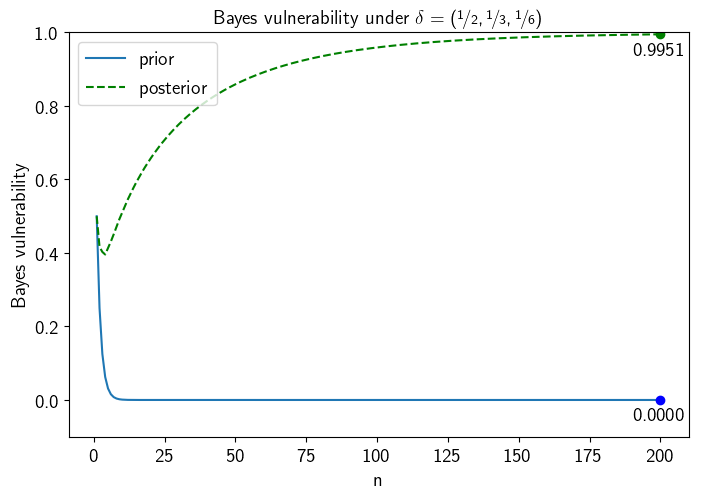

In [135]:
g = graph_bayes_prior_post(200, 3, [1/2, 1/3, 1/6])

In [140]:
n = 200
k = 3
probs = [1/2, 1/4, 1/4]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  6.223015277861142e-61
The posterior bayes vuln:  0.4999859734203035


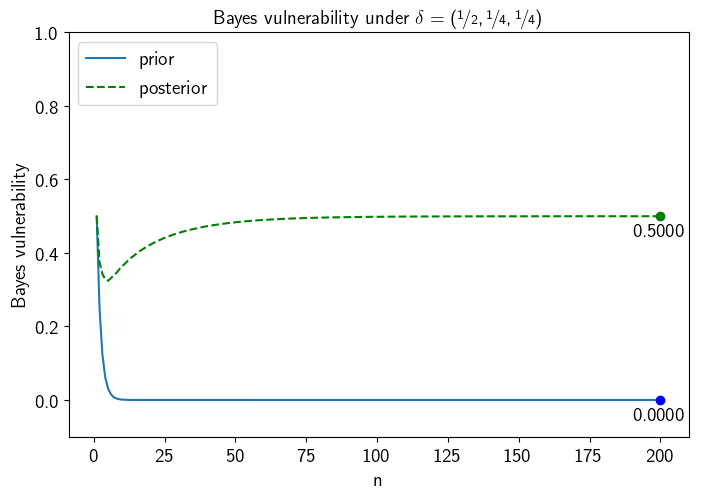

,prior,posterior
0,5.0000000000e-01,0.5000000000
1,2.5000000000e-01,0.3750000000
2,1.2500000000e-01,0.3437500000
3,6.2500000000e-02,0.3281250000
4,3.1250000000e-02,0.3242187500
5,1.5625000000e-02,0.3310546875
6,7.8125000000e-03,0.3393554688
7,3.9062500000e-03,0.3459472656
8,1.9531250000e-03,0.3556518555
9,9.7656250000e-04,0.3642425537


In [141]:
graph_bayes_prior_post(200, 3, [1/2, 1/4, 1/4])

In [33]:
n = 200
k = 3
probs = [1/2, .26, .24]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  6.223015277861142e-61
The posterior bayes vuln:  0.6553398219376529


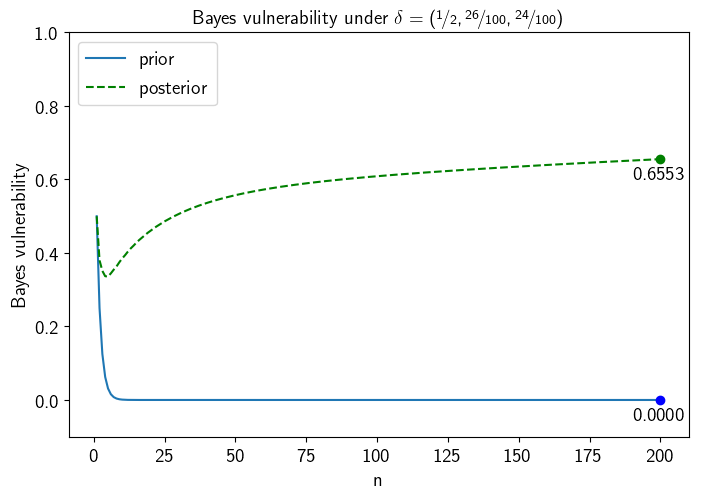

In [143]:
gc = graph_bayes_prior_post(200, 3, [1/2, .26, .24])

In [31]:
n = 200
k = 4
probs = [1/4, 1/4, 1/4, 1/4]
post = nonuni_post_bayes_vuln(n, k, probs)
prior = prior_bayes_vuln(n, probs)
print("The prior bayes vuln: ", prior)
print("The posterior bayes vuln: ", post)

The prior bayes vuln:  3.8725919148493183e-121
The posterior bayes vuln:  0.04166666666666664


In [32]:
graph_bayes_prior_post(200, 4, [1/4, 1/4, 1/4, 1/4])

KeyboardInterrupt: 

### Graph Under Uniform Prior

In [23]:
uni_post_bayes_vs = []
uni_prior_bayes_vs = []
for i in range(range_max):
    uni_post_bayes_vs.append(uni_post_bayes_vuln(i+1, k))
    uni_prior_bayes_vs.append(prior_bayes_vuln(i+1, uni_probs))
uni_bayes_vuln_df = pd.DataFrame(
    {'prior':uni_prior_bayes_vs,
     'posterior':uni_post_bayes_vs
    }
)
uni_bayes_vuln_df.head()

,prior,posterior
0,0.333333,1/3
1,0.111111,2/9
2,0.037037,5/27
3,0.012346,14/81
4,0.004115,41/243


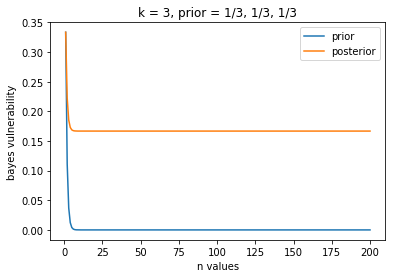

In [24]:
x = [i+1 for i in range(range_max)]

plt.plot(x, 'prior', data=uni_bayes_vuln_df, marker='', label="prior")
plt.plot(x, 'posterior', data=uni_bayes_vuln_df, marker='', label="posterior")
plt.xlabel('n values')
plt.ylabel('bayes vulnerability')

plt.title('k = 3, prior = 1/3, 1/3, 1/3')
plt.legend()
plt.show()

In [23]:
def graph_it_bayes_4(n_range, k, probs, df):
    x = [i+1 for i in range(n_range)]
    y_posterior = df["posterior"].iloc[-1] # saves last posterior y
    y_prior = df["prior"].iloc[-1] # save last prior y for annotation
    
    plt.plot(x, 'prior', 
             data=df,
             label="prior")
    plt.plot(x, 'posterior',
             color='green',
             data=df,
             linestyle='--',
             marker='', 
             label="posterior")
    plt.xlabel('n values')
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1)
    
    # green dot for last y posterior vulnerability
    plt.annotate('%.4f' % y_posterior,
                 xy=[n_range, y_posterior],
                 xytext=(-20, 15),
                 textcoords='offset points')
    plt.plot(n_range, y_posterior, 
             marker = 'o', 
             markerfacecolor='green',
             markeredgecolor='green')
    
    # green dot for last y prior vulnerability
    plt.annotate('%.4f' % y_prior,
                 xy=[n_range, y_prior],
                 xytext=(-20, -15),
                 textcoords='offset points')
    plt.plot(n_range, y_prior, 
             marker = 'o', 
             markerfacecolor='blue',
             markeredgecolor='blue')
    
    # title rounds the prior
    format_probs = ['%.2f' % prob for prob in probs]
    plt.title(f'Prior and Posterior Bayes Vulnerability, k = {k}')
    plt.legend(loc='upper left')
    # legend adjusted so it doesn't run into annotations
    #plt.legend(loc='center left', 
     #         bbox_to_anchor= (1.01, .5),
      #        frameon=False)
    plt.show()
    plt.close()